In [66]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import pandas as pd
from matplotlib.pyplot import *
from importlib import reload
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from copy import deepcopy

# NDNT network libs
import NDNT.utils as utils
import NDNT.NDNT as NDN
from NDNT.modules.layers import ChannelLayer, NDNLayer
from NDNT.networks import FFnetwork

import utils as ut
import lvutils as lv
import mattplotlib as m
import modellib as ml

def redo():
    reload(ut)
    reload(lv)
    reload(m)
    reload(ml)

In [67]:
# load the data
data = ut.load_data('ki_0503_V2b_py.mat')

../../data/hn/ ki_0503_V2b_py.mat
Loaded ki_0503_V2b_py.mat
118679 frames, 31 units, 848 trials with 116 frames each
  Time embedding...
  Time embedding...


In [69]:
# convert to a dataframe
d = ut.dataframe(data)
d

,time,trial,cued,choice,strengthL,strengthR,signalL,signalR,r0,r1,...,r21,r22,r23,r24,r25,r26,r27,r28,r29,r30
0,0.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,2.0,2.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
4,4.0,0.0,1.0,-1.0,0.07,0.27,-1.0,1.0,2.0,1.0,...,2.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118674,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118675,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118676,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118677,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# common LBFGS params

In [6]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=2000,
    history_size=100,
    max_epochs=3,
    max_iter=2000)

# drift (null) model

Mean LL-Drift: 2.5082462


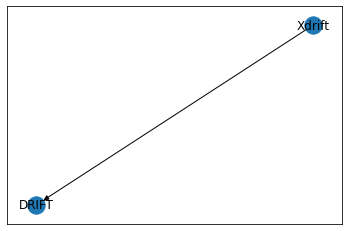

In [7]:
# define the DRIFT, train it before adding it to the network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='softplus')
drift_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}

drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])

# Stand-alone drift model
drift_mod = NDN.NDN(ffnet_list=[drift_net], loss_type='poisson')

# Train the DRIFT Model
drift_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)
# evaluate model using null-adjusted log-likelihood
LLsDrift = drift_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Drift:", np.mean(LLsDrift))

ml.draw_network(drift_mod, names=['DRIFT'])

<Figure size 432x288 with 0 Axes>

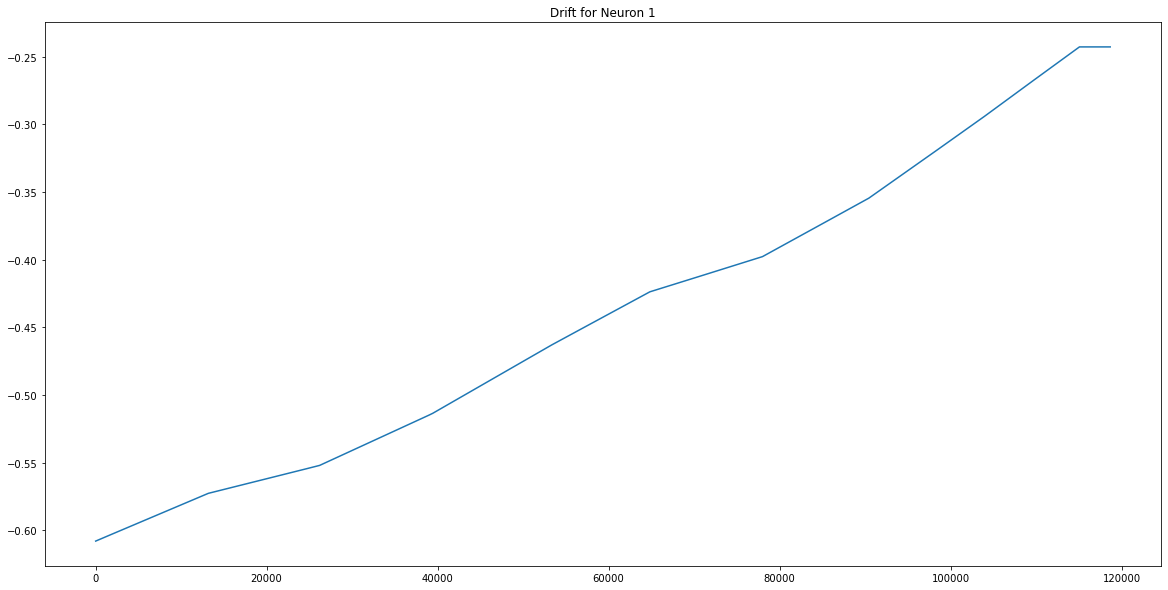

In [13]:
# Check that DRIFT model weights (e.g. predictions), try to make them smoother

# get the weights for the DRIFT network
driftw = drift_mod.networks[0].layers[0].weight.data
data.Xdrift.shape, driftw.shape
# predict the firing rates from the DRIFT
predRs = data.Xdrift @ driftw

m.fig()
plt.plot(predRs[:,0])
plt.title("Drift for Neuron 1")
plt.show()

# autoencoder

In [14]:
# add the smoothed robs into the model as a covariate
sm_robs100 = lv.smooth(data.robs, n=100)
data.add_covariate('smoothed_robs', sm_robs100)
sm_robs100.shape, data.stim_dims

((118679, 31), [1, 11, 1, 12])

<Figure size 432x288 with 0 Axes>

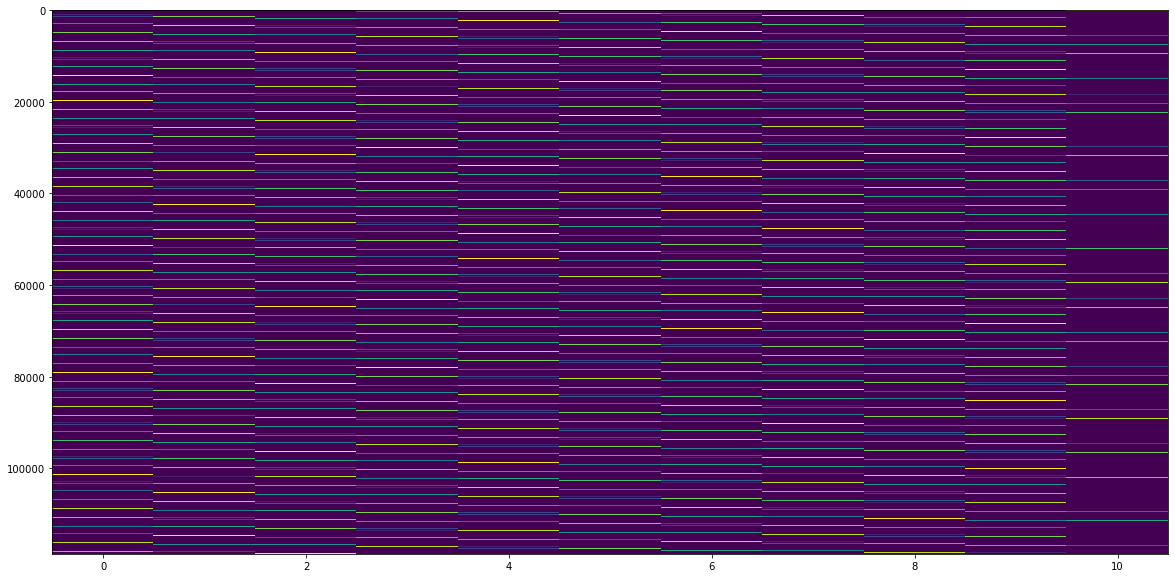

In [15]:
# populate the trials with tents
Xadapt = np.zeros((data.NT, 11))
for trial in data.block_inds:
    tents = data.design_matrix_drift(120, [i for i in range(10, 120, 10)])
    # copy this for each trial into the long list of tents
    Xadapt[trial[0]:trial[-1]] = tents[0:trial[-1]-trial[0]]

# plot the feature for testing
m.fig()
plt.imshow(Xadapt, aspect='auto', interpolation='none')
plt.show()

<Figure size 432x288 with 0 Axes>

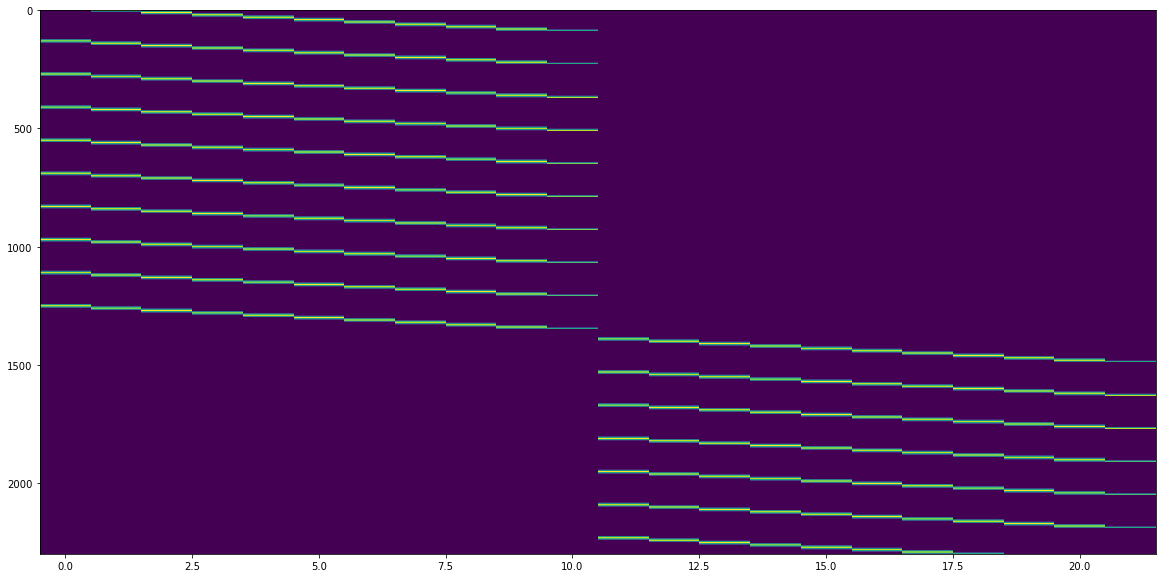

In [16]:
# split Xadapt by cued and uncued trials
trcued = np.where(data.TRcued > 0)[0]
truncued = np.where(data.TRcued < 0)[0]
cued = []
for tr in trcued: cued.extend(data.block_inds[tr])
uncued = []
for tr in truncued: uncued.extend(data.block_inds[tr])

# concatenate these as separate features into a new cued+uncued design matrix
XadaptC = deepcopy(Xadapt)
XadaptU = deepcopy(Xadapt)
XadaptC[uncued] = 0
XadaptU[cued] = 0
XadaptCU = np.array([np.hstack((XadaptC[t,:], XadaptU[t,:])) for t in range(Xadapt.shape[0])])

# add the feature to the dataset
data.add_covariate('XadaptCU', XadaptCU)

# plot the feature for testing
m.fig()
plt.imshow(XadaptCU[5200:7500], aspect='auto', interpolation='none')
plt.show()

Model: M031_N_N_N_NN_A

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 19.70798921585083 sec elapsed
Mean LL-Adapt: 0.12371931


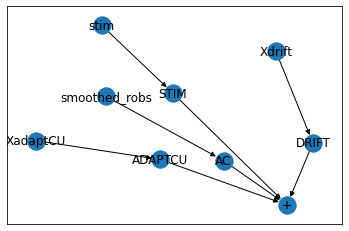

In [17]:
# define the DRIFT network
drift_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, data.Xdrift.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0, # Q: what norm type is this and why should we use it?
    NLtype='lin')
drift_pars['reg_vals'] = {'d2t': 0.2, 'bcs': {'d2t': 0}}
drift_net = FFnetwork.ffnet_dict(xstim_n='Xdrift', layer_list=[drift_pars])


# define the ADAPT network
adapt_pars = NDNLayer.layer_dict(
    input_dims=[1, 1, 1, XadaptCU.shape[1]],
    num_filters=data.NC,
    bias=False,
    norm_type=0,
    NLtype='lin')
adapt_pars['reg_vals'] = {'d2t': 0.1, 'bcs': {'d2t': 0}}
adapt_net = FFnetwork.ffnet_dict(xstim_n='XadaptCU', layer_list=[adapt_pars])


# define the STIM network
stim_layer = NDNLayer.layer_dict(
    input_dims=data.stim_dims,
    num_filters=data.NC,
    bias=False,
    initialize_center=True,
    NLtype='lin')
stim_layer['reg_vals'] = {'d2xt': 0.2, 'bcs':{'d2xt': 1}}
stim_net = FFnetwork.ffnet_dict(xstim_n='stim', layer_list=[stim_layer])


# define the autoencoder network
# input --> LVs (X --> Z)
encoder_layer = NDNLayer.layer_dict(
    # what are these input_dims?
    input_dims=[data.NC, 1, 1, 1], num_filters=7,  # num_LVs --> |Z|
    norm_type=1,  # normalization needed to keep the scale
    # this adjusts the activation threshold by making the output spikes more or less
    bias=False,  # don't put a bias on the input
    NLtype='lin')  # 'lin' -> linear, no nonlinearity applied here
# LVs --> output (Z --> X')
decoder_layer = NDNLayer.layer_dict(
    num_filters=data.NC,
    bias=True, # Q: should we have a bias here? Write out the function.
    NLtype='lin')
# apply L2 regularization on the output
# Q: I don't understand why, though?
decoder_layer['reg_vals'] = {'l2': 0.01}
ac_net = FFnetwork.ffnet_dict(
    xstim_n='smoothed_robs',
    layer_list=[encoder_layer, decoder_layer])


# define the COMBINE network
comb_layer = ChannelLayer.layer_dict(
    num_filters=data.NC,
    NLtype='softplus',
    bias=True)
comb_layer['weights_initializer'] = 'ones'
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1, 2, 3], layer_list=[comb_layer], ffnet_type='add')


# define the COMPLETE model
ac_mod = NDN.NDN(ffnet_list=[drift_net, adapt_net, stim_net, ac_net, comb_net], loss_type='poisson')

# copy the fit drift weights into this network and freeze them
ac_mod.networks[0].layers[0].weight.data = deepcopy(driftw)
ac_mod.set_parameters(val=False, name='weight', ffnet_target=0)


# Draw the network
ml.draw_network(ac_mod, ['DRIFT', 'ADAPTCU', 'STIM', 'AC', '+'] )


# Train the complete model
# it automatically uses the train_inds specified in the Dataset object when calling fit()
ac_mod.fit(data, force_dict_training=True, **lbfgs_pars, verbose=1)

LLsALL = ac_mod.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-Adapt:", np.mean(LLsDrift - LLsALL))

# analyze autoencoder results

<Figure size 432x288 with 0 Axes>

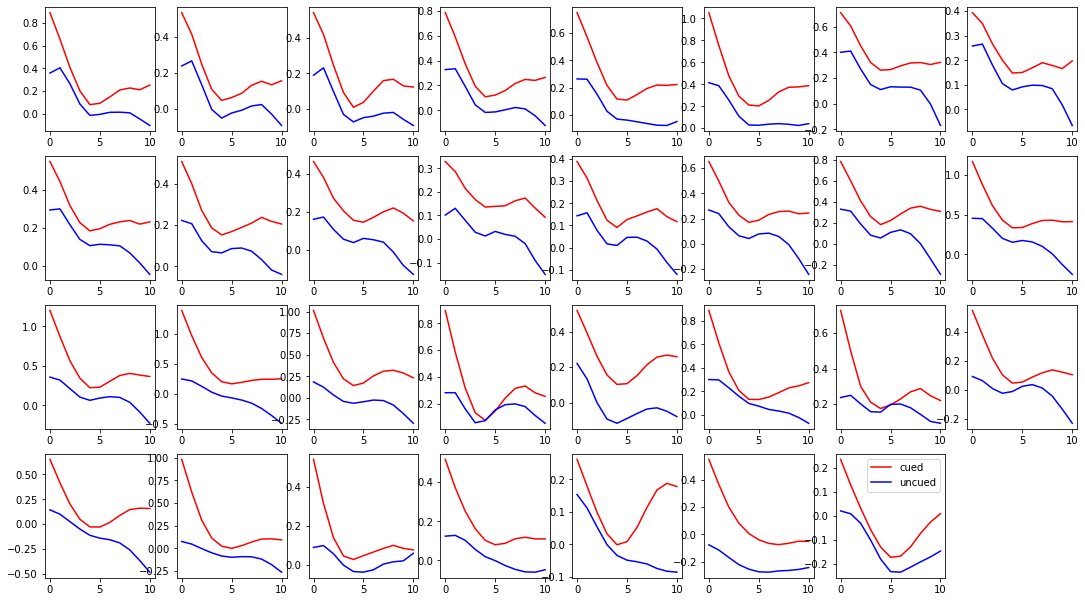

In [20]:
# compare XadaptU with XadaptC weights after fitting the model
fig = m.fig()
fig.set_size_inches(18.5, 10.5)
for c in range(data.NC):
    plt.subplot(4,8, c+1)
    plt.plot(ac_mod.networks[1].layers[0].weight.data[range(0,11), c], 'r', label='cued')
    plt.plot(ac_mod.networks[1].layers[0].weight.data[range(11,22), c], 'b', label='uncued')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

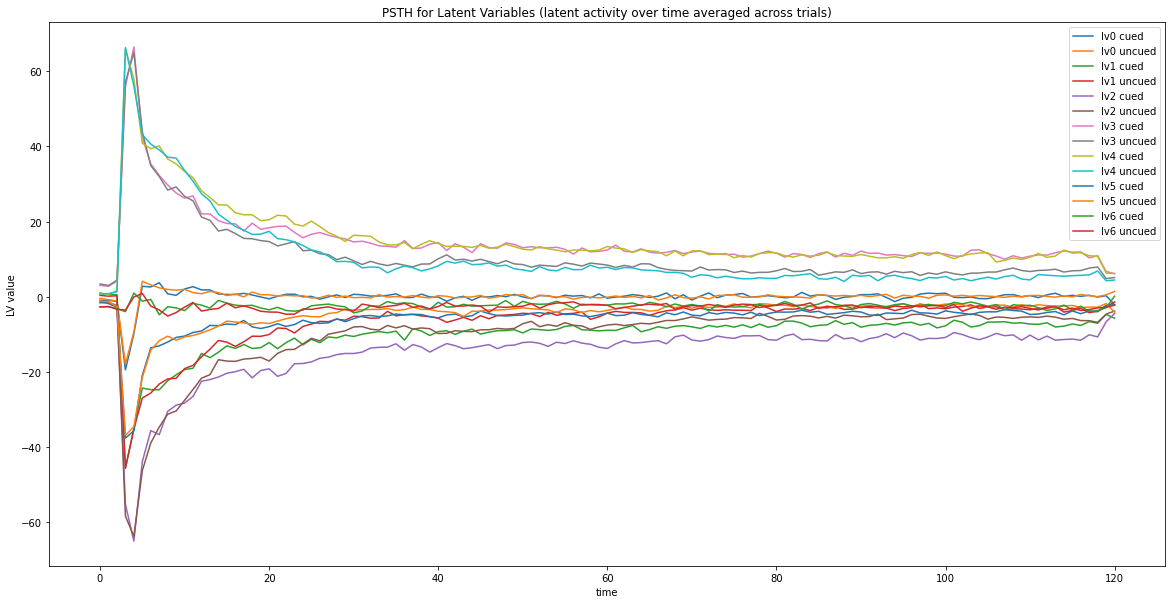

In [74]:
lvs = ac_mod.networks[3].layers[0](data.robs)
for lv in range(0, lvs.shape[1]):
    d['lv'+str(lv)] = lvs[:, lv].detach().numpy()

m.fig()
for lv in range(0, 7):
    plt.plot(d[d.cued == 1].groupby(['time'])['lv'+str(lv)].mean(), label='lv'+str(lv)+' cued')
    plt.plot(d[d.cued == -1].groupby(['time'])['lv'+str(lv)].mean(), label='lv'+str(lv)+' uncued')
plt.xlabel("time")
plt.ylabel("LV value")
plt.title("PSTH for Latent Variables (latent activity over time averaged across trials)")
plt.legend()
plt.show()

# look at correctness over time projected onto attention vector

In [75]:
correct_choiceR = (d.cued == -1) & (d.signalR == d.choice) & (d.strengthR > 0)
correct_choiceL =  (d.cued == 1) & (d.signalL == d.choice) & (d.strengthL > 0)
correct = correct_choiceR | correct_choiceL
d[correct].trial.unique().shape
# These do match the counts on the other notebook (500 correct answers)

(500,)

In [76]:
incorrect_choiceR = (d.cued == -1) & (d.signalR != d.choice) & (d.strengthR > 0)
incorrect_choiceL =  (d.cued == 1) & (d.signalL != d.choice) & (d.strengthL > 0)
incorrect = incorrect_choiceR | incorrect_choiceL
d[incorrect].trial.unique().shape
# These do match the counts on the other notebook (60 incorrect answers)

(68,)

<Figure size 432x288 with 0 Axes>

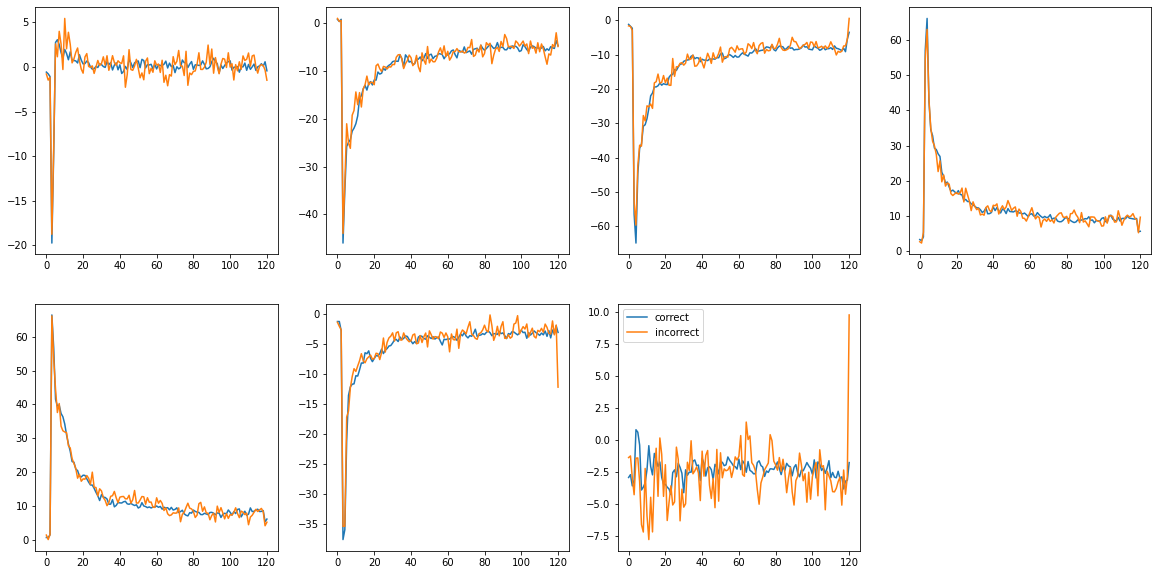

In [83]:
m.fig()
for lv in range(0,7):
    plt.subplot(2,4, lv+1)
    plt.plot(d[correct].groupby(['time'])['lv'+str(lv)].mean(), label='correct')
    plt.plot(d[incorrect].groupby(['time'])['lv'+str(lv)].mean(), label='incorrect')
plt.legend()
plt.show()

In [155]:
# create cued-uncued vector
cued_mean = d[d.cued == -1].loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']].mean(axis=0)
uncued_mean = d[d.cued == 1].loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']].mean(axis=0)
cued_vector = cued_mean - uncued_mean
cued_vector /= np.sqrt(cued_vector @ cued_vector.T)

# create correct-incorrect vector
correct_mean = d[correct].loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']].mean(axis=0)
incorrect_mean = d[incorrect].loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']].mean(axis=0)
correct_vector = correct_mean - incorrect_mean
correct_vector /= np.sqrt(correct_vector @ correct_vector.T)

# project each latent onto each vector and plot in a scatter plot,
# with each vector being an axis to see how these two things evolve together
cuedvals   = d[d.cued == -1].groupby(['time']).mean().loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']][1:]
uncuedvals  = d[d.cued == 1].groupby(['time']).mean().loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']][1:]
correctvals     = d[correct].groupby(['time']).mean().loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']][1:]
incorrectvals = d[incorrect].groupby(['time']).mean().loc[:, ['lv0','lv1','lv2','lv3','lv4','lv5','lv6']][1:]

<Figure size 432x288 with 0 Axes>

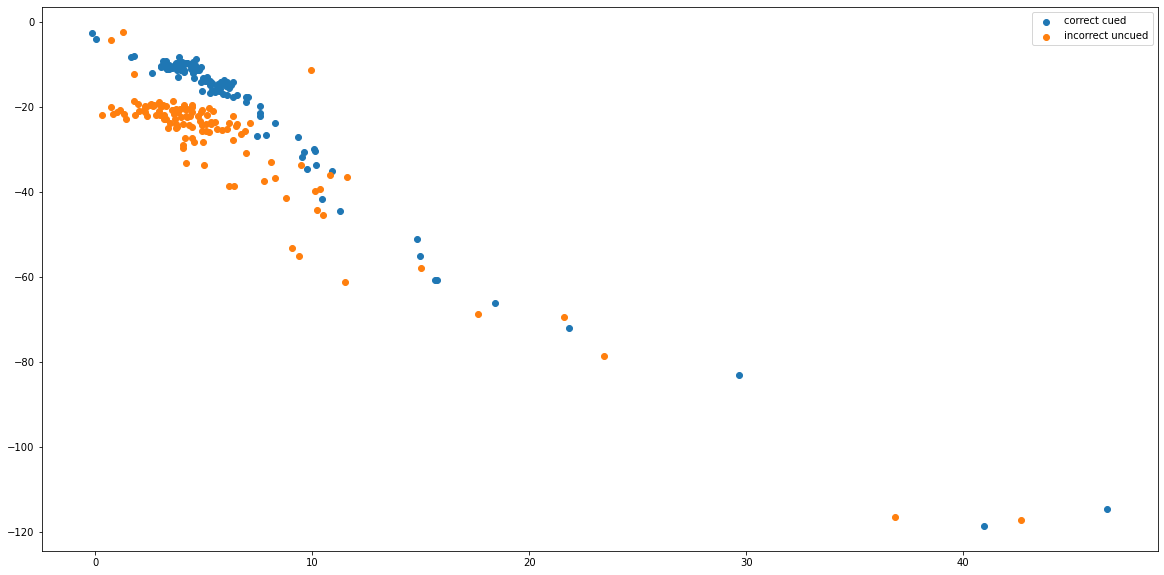

In [180]:
m.fig()
plt.scatter(correct_vector @ correctvals.T, cued_vector @ cuedvals.T, label='correct cued')
plt.scatter(correct_vector @ incorrectvals.T, cued_vector @ uncuedvals.T, label='incorrect uncued')
plt.legend()
plt.show()